In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Union
from scipy import stats

# Часть 1: Генерация и анализ распределений

## Функция для генерации данных

In [25]:
def generate_distribution(distr_type: str, size: int = 1000,
                          noise: float = 0.12, outliers: float = 0.1) -> np.ndarray:
    """
      Генерирует выборку с заданным распределением, добавляет шум и выбросы.

    Аргументы:
        distribution_type: Тип распределения ('normal' или 'uniform').
        size: Размер выборки.
        noise_factor: Фактор шума.
        outliers_percent: Процент выбросов.
    """
    # Генерируем базовое распределение
    if distr_type == 'normal':
        data = np.random.normal(loc=0, scale=1, size=size)
    elif distr_type == 'uniform':
        data = np.random.uniform(low=-2, high=2, size=size)
    else:
        raise ValueError("Неверный тип распределения.")

    # Добавляем шум
    data += np.random.normal(0, noise, size)

    # Добавляем выбросы
    outliers_count = int(size * outliers)
    outliers_indices = np.random.choice(size, outliers_count, replace=False)
    data[outliers_indices] += np.random.uniform(2, 5, outliers_count) * np.sign(data[outliers_indices])

    return data

## Функция сбора статистик

In [67]:
def calculate_statistics(data: np.ndarray):
    """
    Description:
      Рассчитывает основные статистические характеристики выборки.

    Args:
        data: Входная выборка.
    """
    mean = np.mean(data)
    median = np.median(data)
    try:
        mode_result = stats.mode(data, nan_policy='omit')
        if isinstance(mode_result, tuple):  # Для старых версий SciPy
            mode = mode_result[0][0]
        else:  # Для новых версий SciPy
            mode = mode_result.mode[0]
    except:
        # Обрабатываем случай, когда мода не может быть определена
        unique, counts = np.unique(data, return_counts=True)
        max_count = np.max(counts)
        if np.sum(counts == max_count) > 1:
            mode = "Мультимодальное распределение"
        else:
            mode = unique[np.argmax(counts)]

    return mean, median, mode


In [65]:

print('Мода =', stats.mode(data))

Мода = ModeResult(mode=-6.632519326439134, count=1)


## Визуализация

In [42]:
def visualize(data: np.ndarray, plot_type: str = 'histogram'):
    """
    Description:
      Визуализирует данные с помощью выбранного типа графика.

    Args:
        data: Входная выборка.
        plot_type: 'histogram', 'scatter', 'boxplot'.
    """

    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    sns.set_palette("muted")

    if plot_type == 'histogram':
        sns.histplot(data, kde=True, color='steelblue', bins=30)
        plt.title('Гистограмма распределения', fontsize=16)
    elif plot_type == 'scatter':
        sns.scatterplot(x=range(len(data)), y=data, hue=data, legend=False)
        plt.title('График рассеивания', fontsize=16)
    elif plot_type == 'boxplot':
        sns.boxplot(data=data, color='lightgreen')
        plt.title('Диаграмма размаха ("ящик с усами")', fontsize=16)
    else:
        raise ValueError("Неверный тип графика. Используйте 'histogram', 'scatter' или 'boxplot'.")

    plt.xlabel('Значение', fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.tight_layout()
    plt.show()

In [11]:

def generate_skewed_distribution(size: int = 1000, skewness: float = 0.5):
    """
      Генерирует распределение со смещенной медианой относительно среднего.

    Args:
        size: Размер выборки.
        skewness: Степень асимметрии (0 - симметричное, >0 - правосторонняя асимметрия, <0 - левосторонняя).

    Returns:
        np.ndarray: Сгенерированная выборка.
    """
    from scipy.stats import skewnorm
    # Генерируем распределение с заданной асимметрией
    skewed_data = skewnorm.rvs(a=skewness, size=size)
    return skewed_data

In [12]:
def generate_skewed_distribution_with_target_shift(size: int = 1000, target_shift: float = 15.0) -> np.ndarray:
    """
      Генерирует распределение со смещенной медианой относительно среднего с целевым относительным смещением.

    Args:
        size: Размер выборки.
        target_shift: Целевое относительное смещение медианы от среднего (в процентах).

    Returns:
        np.ndarray: Сгенерированная выборка.

    Raises:
        ValueError: Если не удалось достичь целевого смещения за заданное количество итераций.
    """
    skewness_min = -20
    skewness_max = 20
    tolerance = 0.01  # Допустимая погрешность
    max_iterations = 1000  # Максимальное количество итераций

    for _ in range(max_iterations):
        skewness = (skewness_min + skewness_max) / 2
        skewed_data = generate_skewed_distribution(size, skewness)

        mean = np.mean(skewed_data)
        median = np.median(skewed_data)
        std_dev = np.std(skewed_data)
        median_mean_diff = abs(median - mean)
        relative_shift = (median_mean_diff / std_dev) * 100

        if abs(relative_shift - target_shift) < tolerance:
            print(f"Достигнуто относительное смещение {relative_shift:.2f}% при асимметрии {skewness:.4f}")
            return skewed_data

        if relative_shift < target_shift:
            skewness_min = skewness
        else:
            skewness_max = skewness
    else:
        raise ValueError(f"Не удалось достичь целевого смещения {target_shift}% за {max_iterations} итераций.")

In [68]:
def analyze_distribution(data: np.ndarray, title: str):
    """
        data: Входная выборка.
        title: Заголовок для графика.
    """
    mean, median, mode = calculate_statistics(data)
    if mode[1] == 1:
        mode = 'Мультимодальное распределение'
    #cnt_mode = mode.count

    print(f"\n{title}")
    print(f"Среднее: {mean:.4f}")
    print(f"Медиана: {median:.4f}")
    if isinstance(mode, (int, float)):
        print(f"Мода: {mode:.4f}")
    else:
        print(f"Мода: {mode}")
    # Вычисляем статистические показатели
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    variance = np.var(data)      # Дисперсия
    std_dev = np.std(data)       # Стандартное отклонение
    median_mean_diff = abs(median - mean)
    relative_shift = (median_mean_diff / std_dev) * 100  # Используем стандартное отклонение

    print(f"Первый квартиль (Q1): {q1:.4f}")
    print(f"Третий квартиль (Q3): {q3:.4f}")
    print(f"Размах: {np.max(data) - np.min(data):.4f}")
    print(f"Дисперсия: {variance:.4f}")
    print(f"Стандартное отклонение: {std_dev:.4f}")
    print(f"Относительное смещение медианы от среднего: {relative_shift:.2f}%")

    # Визуализируем гистограмму распределения
    plt.figure(figsize=(12, 6))
    sns.histplot(data, kde=True, bins=20)
    plt.axvline(mean, color='red', linestyle=':', label='Среднее')
    plt.axvline(median, color='green', linestyle='--', label='Медиана')
    plt.title(title, fontsize=16)
    plt.xlabel('Значение', fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Визуализируем диаграмму размаха
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data, color='orange')
    plt.title(f'Диаграмма размаха: {title}', fontsize=16)
    plt.ylabel('Значение', fontsize=14)
    plt.tight_layout()
    plt.show()

Часть 1: Генерация и анализ распределений

Распределение: normal (с шумом и выбросами)
Среднее: 0.0379
Медиана: -0.0230
Мода: Мультимодальное распределение
Первый квартиль (Q1): -0.7457
Третий квартиль (Q3): 0.6661
Размах: 13.5532
Дисперсия: 1.9324
Стандартное отклонение: 1.3901
Относительное смещение медианы от среднего: 4.38%


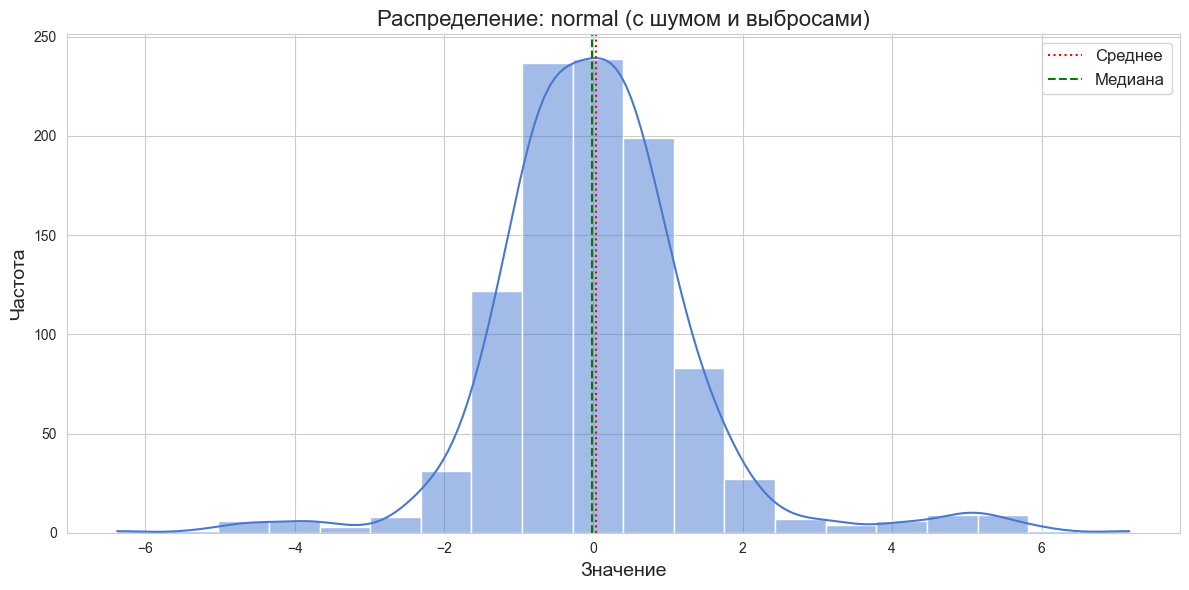

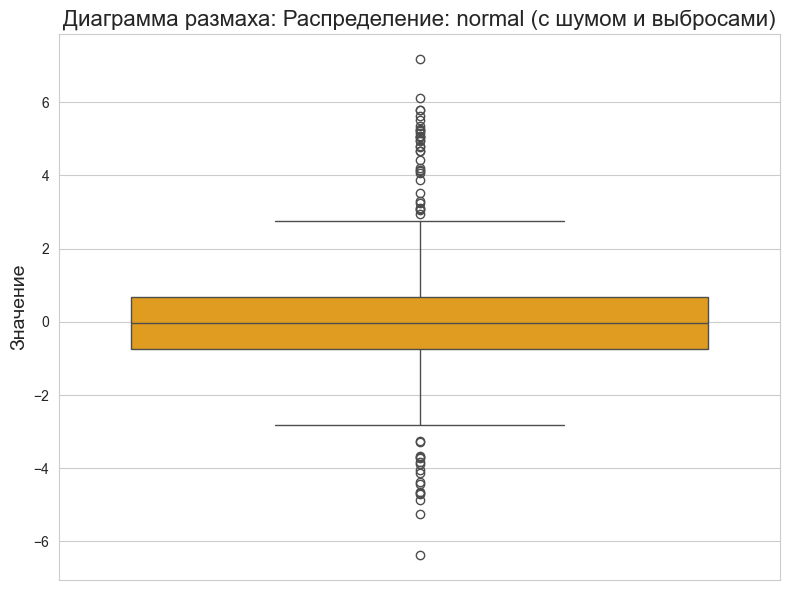

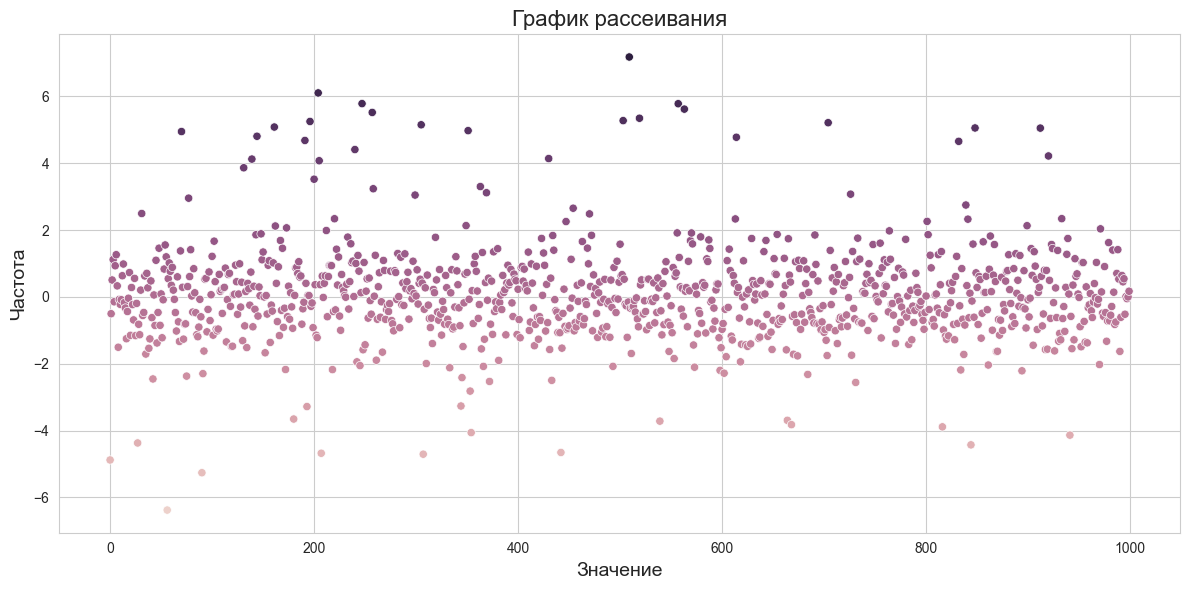


Распределение: uniform (с шумом и выбросами)
Среднее: -0.0211
Медиана: -0.0349
Мода: Мультимодальное распределение
Первый квартиль (Q1): -1.0533
Третий квартиль (Q3): 1.1204
Размах: 12.7821
Дисперсия: 2.3105
Стандартное отклонение: 1.5200
Относительное смещение медианы от среднего: 0.91%


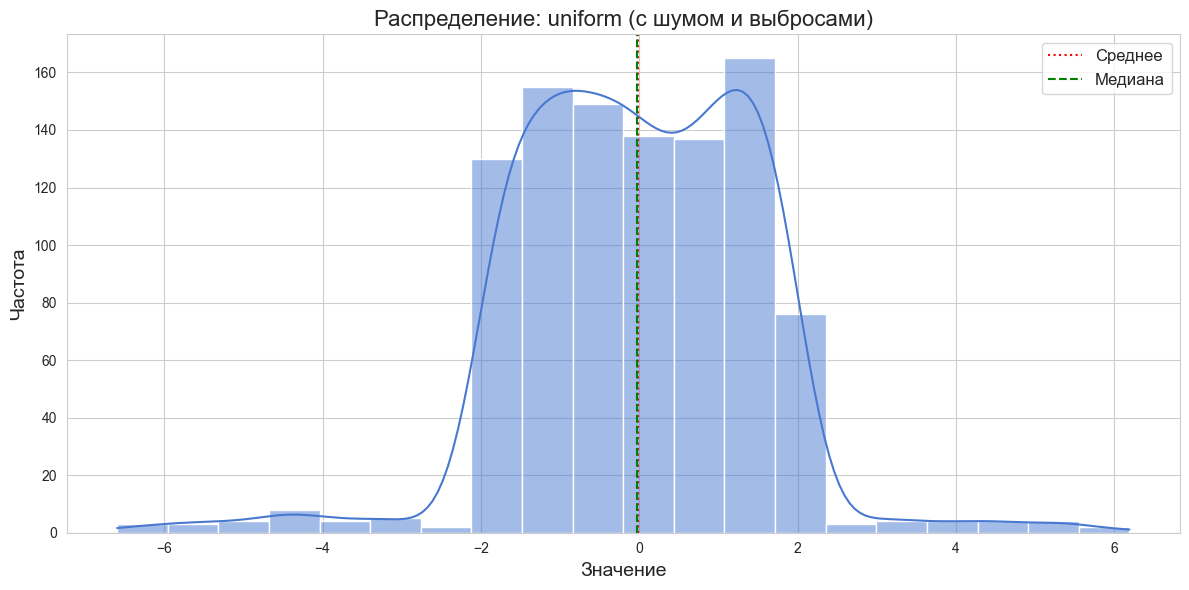

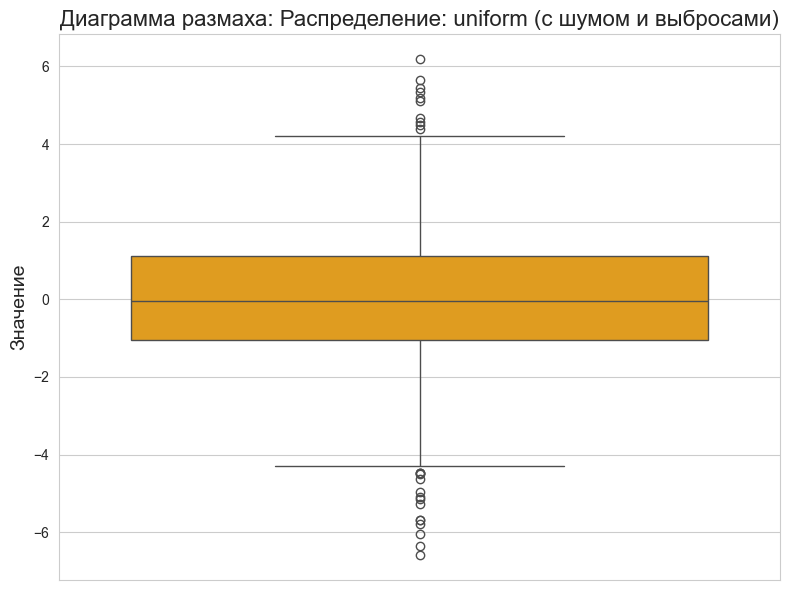

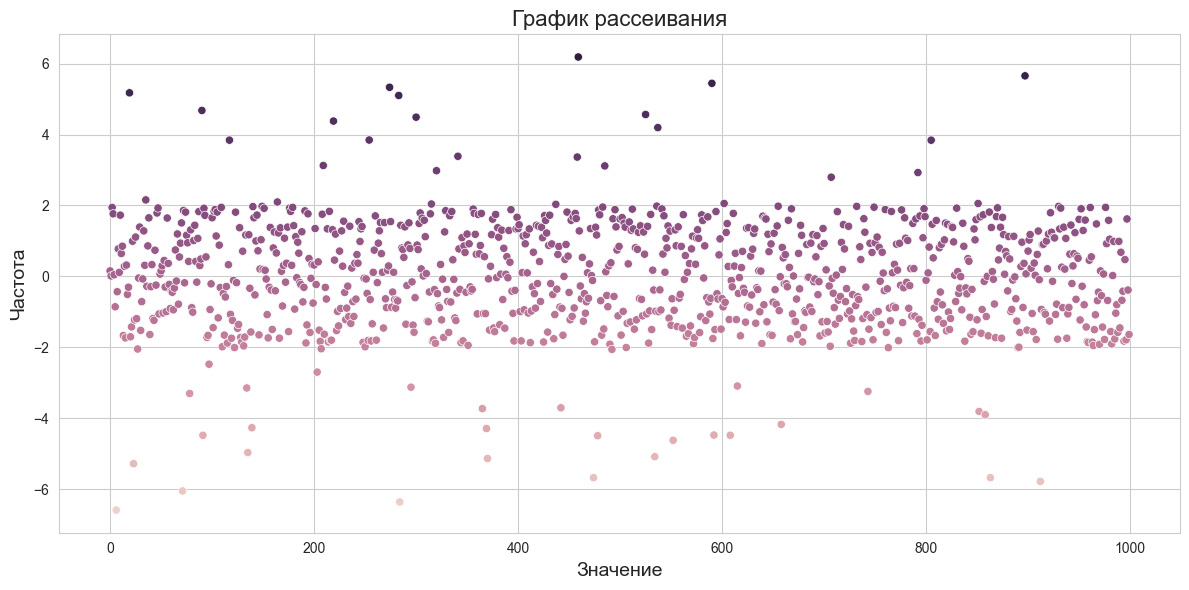

Достигнуто относительное смещение 15.00% при асимметрии 4.0099

Распределение со смещением медианы на 15%
Среднее: 0.7550
Медиана: 0.6626
Мода: Мультимодальное распределение
Первый квартиль (Q1): 0.3015
Третий квартиль (Q3): 1.1472
Размах: 3.5682
Дисперсия: 0.3798
Стандартное отклонение: 0.6163
Относительное смещение медианы от среднего: 15.00%


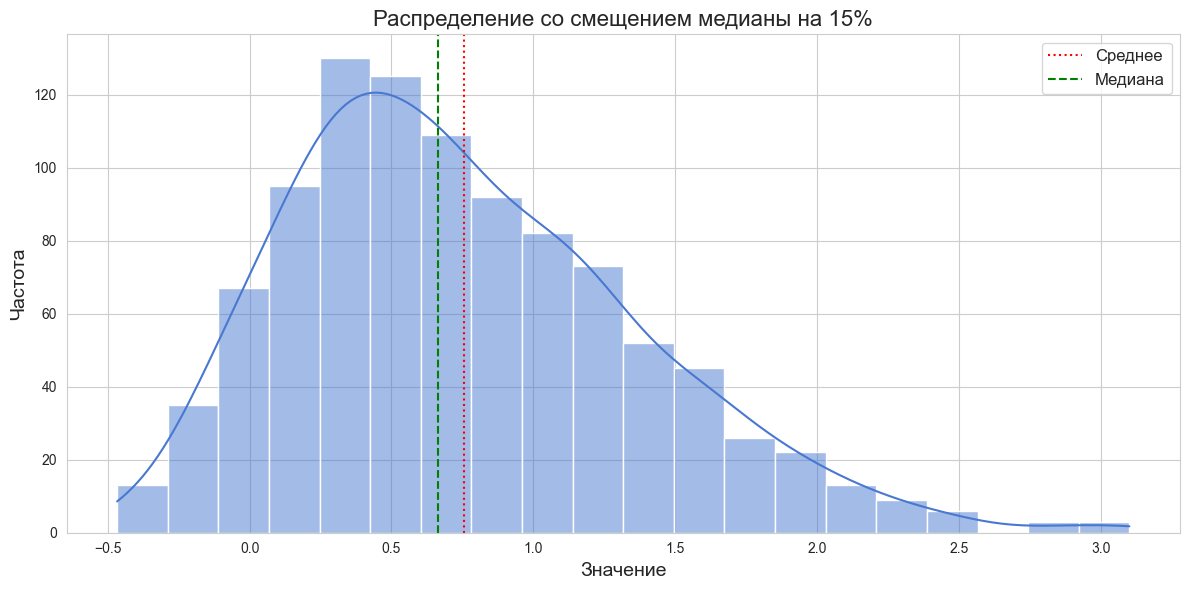

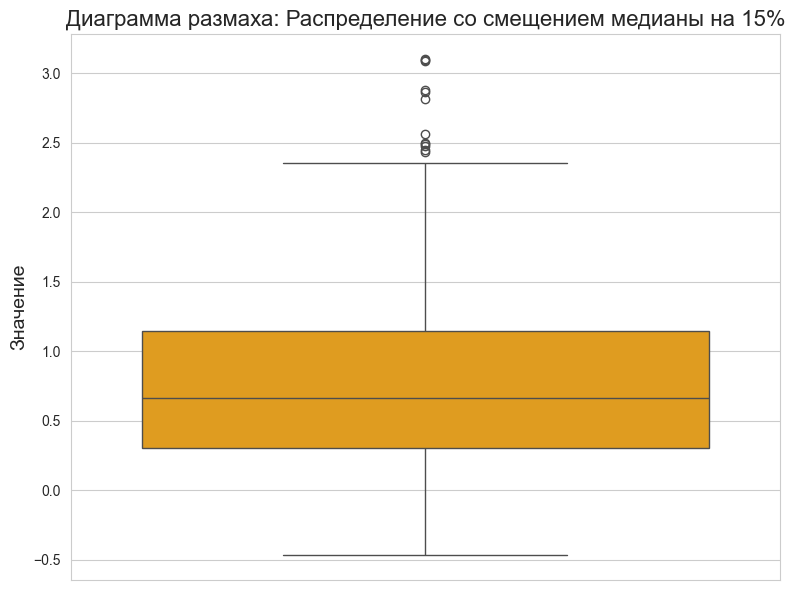

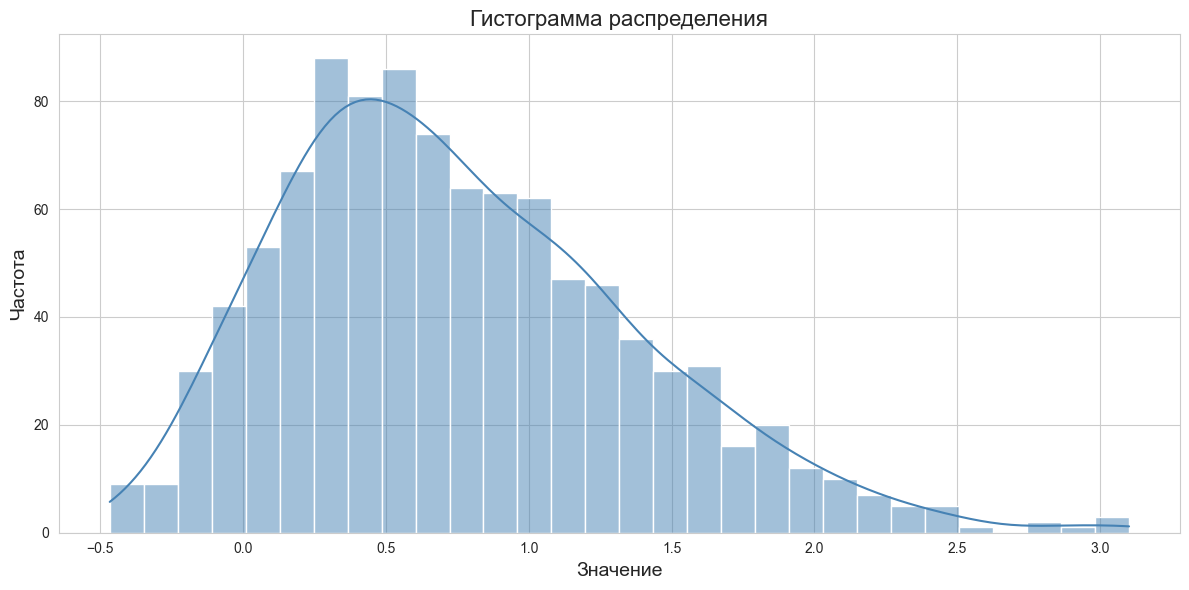


Распределение с несмещенной медианой
Среднее: -0.0061
Медиана: -0.0032
Мода: Мультимодальное распределение
Первый квартиль (Q1): -0.6994
Третий квартиль (Q3): 0.6850
Размах: 6.7115
Дисперсия: 1.0086
Стандартное отклонение: 1.0043
Относительное смещение медианы от среднего: 0.29%


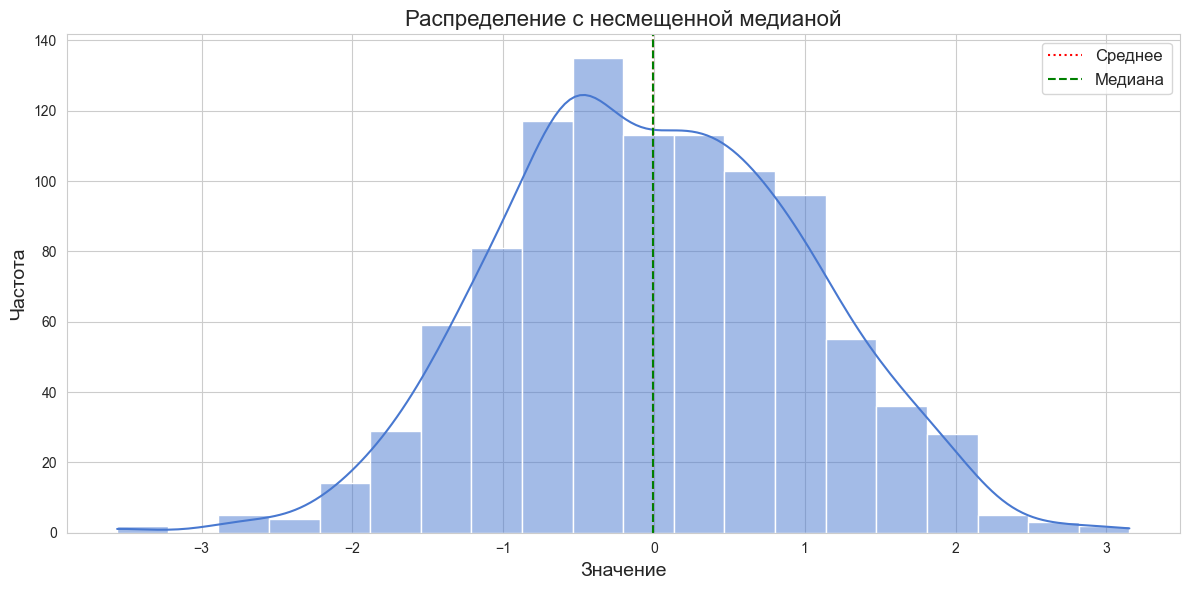

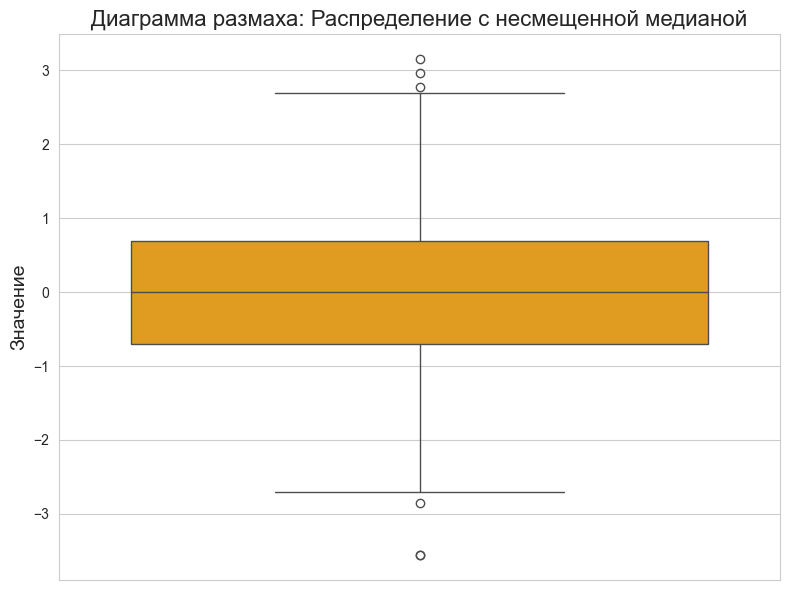

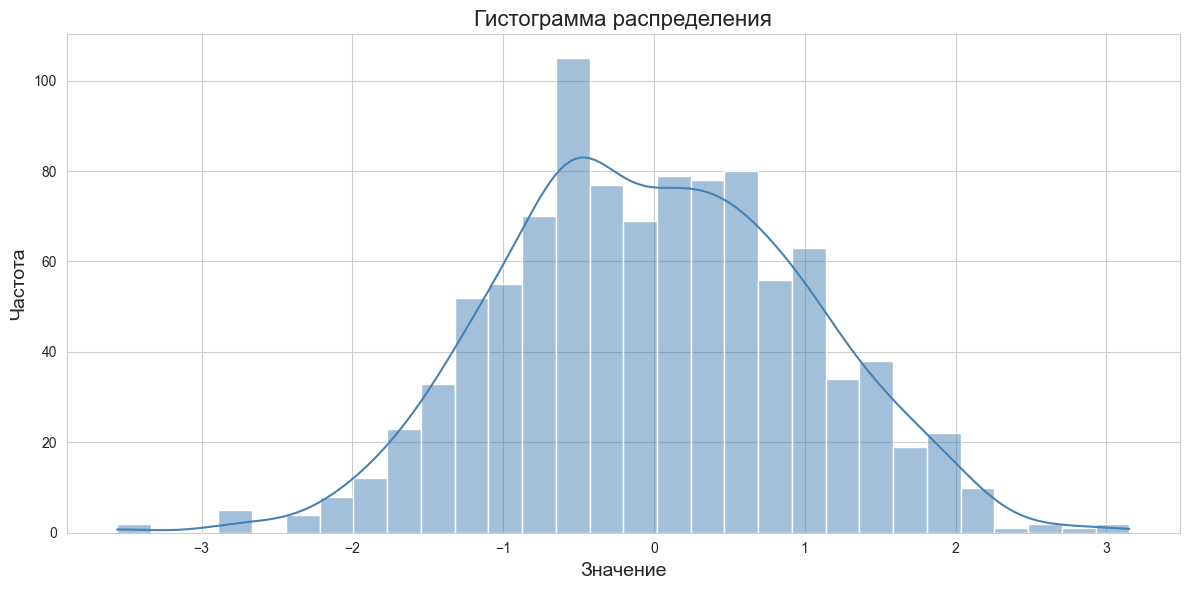

In [70]:
#Нормальное и равномерное распределения с шумом и выбросами
distributions = ['normal', 'uniform']
for dist in distributions:
    data = generate_distribution(dist, noise=0.1, outliers=0.05)
    analyze_distribution(data, f"Распределение: {dist} (с шумом и выбросами)")
    visualize(data, 'scatter')
    print("="*70)

#Распределение со смещенной медианой с целевым смещением 15%
skewed_data = generate_skewed_distribution_with_target_shift(size=1000, target_shift=15.0)
analyze_distribution(skewed_data, "Распределение со смещением медианы на 15%")
visualize(skewed_data, 'histogram')

print("="*70)

#Распределение с несмещенной медианой
unskewed_data = generate_distribution('normal', noise=0, outliers=0)
analyze_distribution(unskewed_data, "Распределение с несмещенной медианой")
visualize(unskewed_data, 'histogram')


## Часть 2. Аномальные значения